# Imports


In [1]:
# general imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

In [3]:
# utility imports
import os
from tqdm import tqdm

In [12]:
import warnings

warnings.filterwarnings("ignore")

# Configuration


In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 3
BATCH_SIZE = 32
LEARNING_RATE = 1e-3  # karpathy constant

INPUT_DIM = 784
HIDDEN_DIM = 64
LATENT_DIM = 16
BETA = 1
GRAD_NORM_CLIP = 1

In [5]:
# Convert vector to image
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x


# Display images, n=max number of images to show
def display_images(in_raw, out_raw, n=1):
    out_raw = out_raw[:n]
    if in_raw is not None:
        in_raw = in_raw[:n]
        in_pic = to_img(in_raw.cpu().data).view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(n):
            plt.subplot(1, n, i + 1)
            plt.imshow(in_pic[i])
            plt.axis("off")
    out_pic = to_img(out_raw.cpu().data).view(-1, 28, 28)
    plt.figure(figsize=(18, 6))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(out_pic[i])
        plt.axis("off")
    plt.show()

# Dataloader and dataset


In [6]:
class FashionMnistDatset(Dataset):
    def __init__(
        self, img_file: str, transform=None, subset=None, device: str = DEVICE
    ) -> None:
        super().__init__()
        self.imgs = pd.read_csv(img_file)
        if subset is not None:
            self.imgs = self.imgs.loc[subset, :].reset_index(drop=True)
        self.labels = torch.tensor(self.imgs["label"], device=device)
        self.imgs.drop(columns=["label"], inplace=True)
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = torch.tensor(self.imgs.iloc[index, :]).float() / 255
        if self.transform:
            img = self.transform(img)
        img = img.to(self.device)
        return img, self.labels[index]

    def show(self, index):
        img = torch.tensor(self.imgs.loc[index, :]).view((28, 28)).float()
        label = self.labels[index]
        plt.imshow(img, cmap="gray")
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title(f"Label: {label}")
        plt.tight_layout()
        plt.show()

To get the Normalise transform for the dataset, we will first need to compute the mean and standard deviation of all te pixels from the training dataset


In [7]:
# data = pd.read_csv("../data/fashion-mnist/fashion-mnist_train.csv")
# pixel_values = data.drop(columns=["label"]).values.flatten()
# pixel_mean = pixel_values.mean()
# pixel_std = pixel_values.std()

# Calculate once and store it by copying it
# doing the pixel_values calc is memory heavy
# pixel_mean = 72.9568306122449
# pixel_std = 89.96686298512094

# transform = torchvision.transforms.Compose(
#     [torchvision.transforms.Normalize(mean=(pixel_mean), std=(pixel_std))]
# )
# dataset = FashionMnistDatset("../data/fashion-mnist/fashion-mnist_test.csv")

# VAE

plan for the vae

input img $\rightarrow$ hidden dim $\rightarrow$ latent dim $\rightarrow$ mean $\mu$ and std $\sigma$ $\rightarrow$ Reparameterise to get z $\rightarrow$ decoder $\rightarrow$ output img


In [7]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int) -> None:
        super().__init__()
        # dimensions
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # encoder stuff
        self.img_to_hidden = nn.Linear(input_dim, hidden_dim)
        # Latent vector is a latent_dim x 1 column vector
        # hence mean for it should be also latent_dim x 1
        # same for standard deviation
        self.hidden_to_latent_mean = nn.Linear(hidden_dim, latent_dim)
        self.hidden_to_latent_logvar = nn.Linear(hidden_dim, latent_dim)

        # decoder stuff
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.hidden_to_img = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encoder(self, x):
        h = self.relu(self.img_to_hidden(x))
        mean = self.hidden_to_latent_mean(h)
        logvar = self.hidden_to_latent_logvar(h)
        std = logvar.mul(0.5).exp().sqrt()
        return mean, std

    def decoder(self, z):
        h = self.relu(self.latent_to_hidden(z))
        out = self.sigmoid(self.hidden_to_img(h))
        return out

    def sampler(self, mean, std):
        if self.training:
            epsilon = torch.randn_like(std)
            z_reparameterised = mean + std * epsilon
            return z_reparameterised
        else:
            return mean

    def generate(self, N):
        z = torch.randn((N, self.latent_dim), device=DEVICE)
        x_generated = self.decoder(z)
        return x_generated

    def forward(self, x):
        mean, std = self.encoder(x)
        z_reparameterised = self.sampler(mean, std)
        x_reconstructed = self.decoder(z_reparameterised)
        return x_reconstructed, mean, std

In [9]:
model = VariationalAutoEncoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)
print(summary(model=model, input_size=(BATCH_SIZE, INPUT_DIM)))

Layer (type:depth-idx)                   Output Shape              Param #
VariationalAutoEncoder                   [32, 784]                 --
├─Linear: 1-1                            [32, 64]                  50,240
├─ReLU: 1-2                              [32, 64]                  --
├─Linear: 1-3                            [32, 16]                  1,040
├─Linear: 1-4                            [32, 16]                  1,040
├─Linear: 1-5                            [32, 64]                  1,088
├─ReLU: 1-6                              [32, 64]                  --
├─Linear: 1-7                            [32, 784]                 50,960
├─Sigmoid: 1-8                           [32, 784]                 --
Total params: 104,368
Trainable params: 104,368
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.34
Input size (MB): 0.10
Forward/backward pass size (MB): 0.24
Params size (MB): 0.42
Estimated Total Size (MB): 0.76


# Training loop


In [8]:
def train_one_epoch(epoch, model, train_dataloader, optimiser, loss_fn):
    loop = tqdm(train_dataloader, unit=" batch")
    training_loss = 0
    for i, (x, _) in enumerate(loop):
        loop.set_description_str(f"Epoch = {epoch}")

        # forward pass
        x = x.to(DEVICE)
        x_reconstructed, mean, std = model(x)

        # loss computation
        reconstruction_loss = loss_fn(x_reconstructed, x)
        kl_divergence = -torch.sum(1 + torch.log(std.pow(2)) - mean.pow(2) - std.pow(2))
        loss = reconstruction_loss + BETA * kl_divergence
        training_loss += loss.cpu().item()

        # backprop
        optimiser.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_NORM_CLIP)
        optimiser.step()

        loop.set_postfix_str(f"Loss = {loss.item(): .3f}")
    print(f"===> Epoch {epoch}")
    print(f"\tAverage train loss = {training_loss / len(train_dataloader) :.3f}")


def train(model, train_datalaoder, test_dataloader, optimiser, loss_fn):
    for epoch in range(EPOCHS):
        model.train()
        train_one_epoch(epoch + 1, model, train_datalaoder, optimiser, loss_fn)

        model.eval()
        validate(model, test_dataloader, loss_fn)


def validate(model, test_dataloader, loss_fn):
    testing_loss = 0
    with torch.no_grad():
        for i, (x, _) in enumerate(test_dataloader):
            # forward pass
            x = x.to(DEVICE)
            x_reconstructed, mean, std = model(x)

            # loss
            reconstruction_loss = loss_fn(x_reconstructed, x)
            kl_divergence = torch.sum(
                1 + torch.log(std.pow(2)) - mean.pow(2) - std.pow(2)
            )
            loss = reconstruction_loss + BETA * kl_divergence
            testing_loss += loss.cpu().item()
        print(f"\tAverage test loss: {testing_loss / len(test_dataloader) :.3f}")

In [9]:
def save_model(model, name):
    torch.save(model.state_dict(), f"../saved-model/{name}.pth")


def load_model(model, name):
    model.load_state_dict(torch.load(f"../saved-model/{name}.pth"))


def train_network(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    name: str,
):
    optimiser = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss(reduction="sum")
    train(model, train_dataloader, test_dataloader, optimiser, loss_fn)
    save_model(model, name)

In [10]:
train_dataset = FashionMnistDatset("../data/fashion-mnist/fashion-mnist_train.csv")
test_dataset = FashionMnistDatset("../data/fashion-mnist/fashion-mnist_test.csv")

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512)

# Model results


## Small network

A very small model, with 63 neurons in the hidden layers and latent space has a dimension of just 16


In [19]:
HIDDEN_DIM = 64
LATENT_DIM = 16
model = VariationalAutoEncoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).to(DEVICE)
train_network(model, train_dataloader, test_dataloader, "trial-1")

Epoch = 1: 100%|██████████| 1875/1875 [01:25<00:00, 21.82 batch/s, Loss =  1243.577]


===> Epoch 1
	Average train loss = 1476.074
	Average test loss: 16204.350


Epoch = 2: 100%|██████████| 1875/1875 [01:27<00:00, 21.51 batch/s, Loss =  1136.725]


===> Epoch 2
	Average train loss = 1144.286
	Average test loss: 15202.056


Epoch = 3: 100%|██████████| 1875/1875 [01:38<00:00, 19.11 batch/s, Loss =  875.980] 


===> Epoch 3
	Average train loss = 1091.121
	Average test loss: 14509.300


### Images generated by the model from randomly sampled $z$ in the latent space


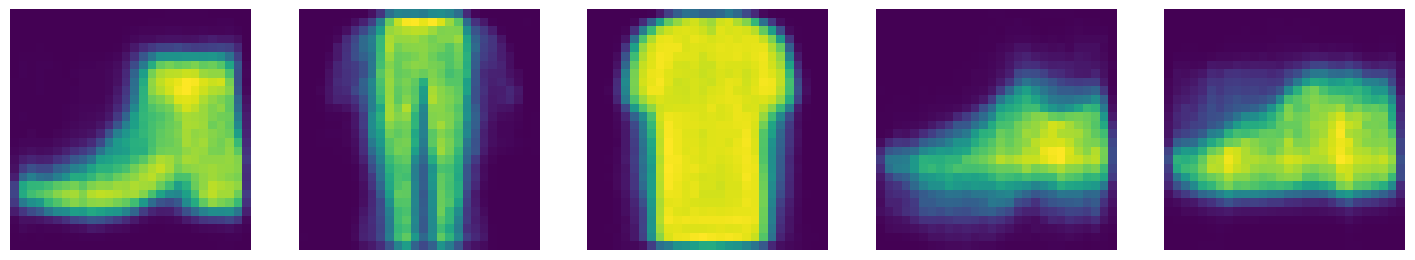

In [12]:
N = 5
display_images(None, model.generate(N), N)

So even with a small network and after training for only 3 epochs, the model can generated pretty well recognisable images from the randomly sampled $z$ in the latent space.


## Bigger network than before


Hidden layer dimension of 256, and latent space dimension of 128


In [24]:
HIDDEN_DIM = 256
LATENT_DIM = 128
model = VariationalAutoEncoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).to(DEVICE)
train_network(model, train_dataloader, test_dataloader, "trial-2")

Epoch = 1: 100%|██████████| 1875/1875 [01:31<00:00, 20.56 batch/s, Loss =  1350.493]


===> Epoch 1
	Average train loss = 1522.453
	Average test loss: 17681.597


Epoch = 2: 100%|██████████| 1875/1875 [01:34<00:00, 19.86 batch/s, Loss =  998.147] 


===> Epoch 2
	Average train loss = 1229.572
	Average test loss: 16440.666


Epoch = 3: 100%|██████████| 1875/1875 [01:48<00:00, 17.31 batch/s, Loss =  1159.585]


===> Epoch 3
	Average train loss = 1106.444
	Average test loss: 15414.299


### Images generated by the model from randomly sampled $z$ in the latent space


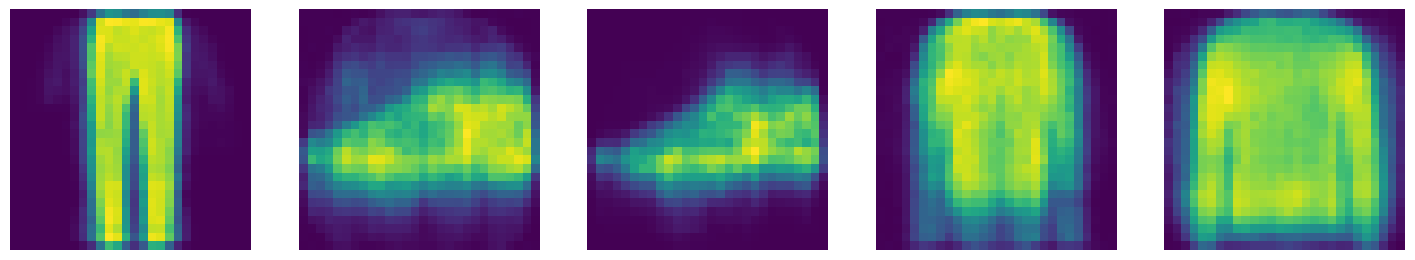

In [14]:
N = 5
display_images(None, model.generate(N), N)

Curiously enough, a bigger model necessarily did not give better results


# Interpolating between two images


In [11]:
HIDDEN_DIM = 64
LATENT_DIM = 16
model = VariationalAutoEncoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).to(DEVICE)
load_model(model, "trial-1")

In [13]:
img_batch, _ = next(iter(test_dataloader))
img_batch = img_batch.to(DEVICE)

In [17]:
np.random.seed(42)
images_to_interpolate = np.random.choice(a=range(512), size=(5, 2), replace=False)

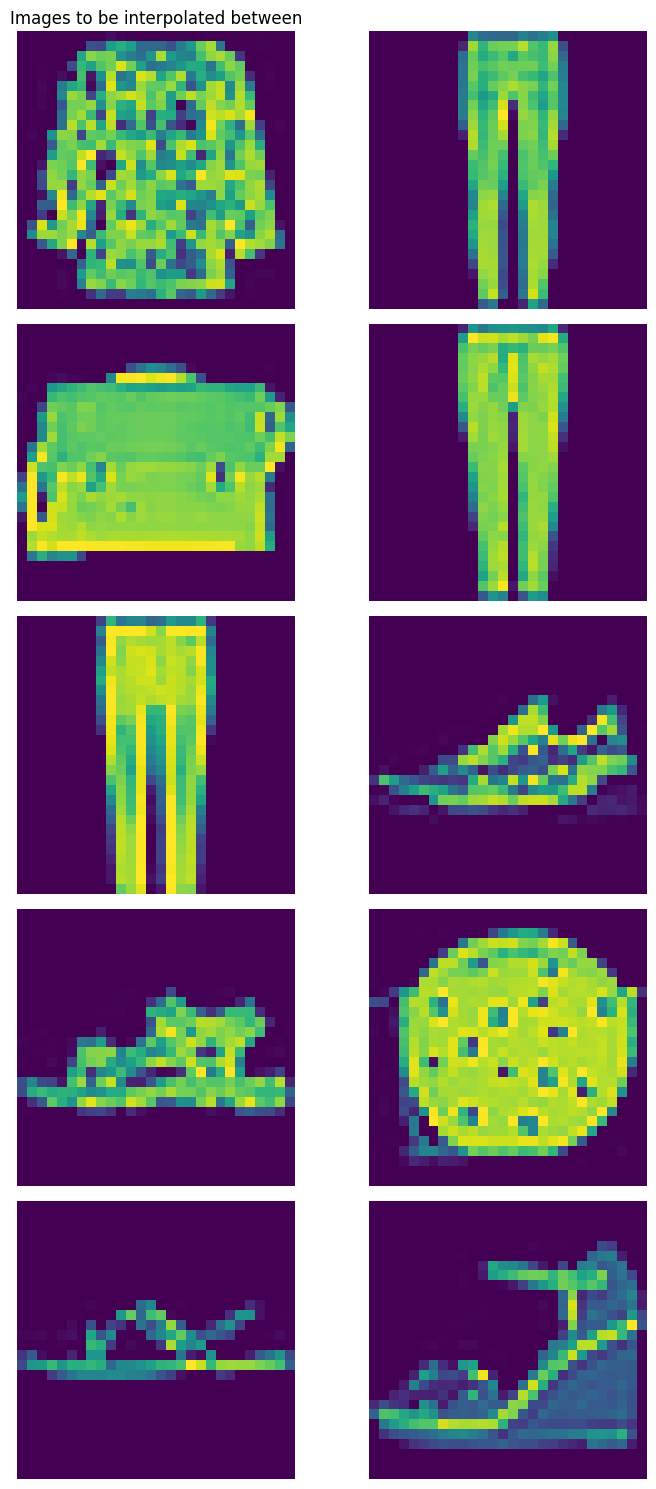

In [47]:
fig, axs = plt.subplots(5, 2, figsize=(8, 15))
axs[0][0].set_title("Images to be interpolated between")
for i, pair in enumerate(images_to_interpolate):
    image_A, image_B = img_batch[pair].view(-1, 28, 28).cpu()

    axs[i][0].imshow(image_A)
    axs[i][1].imshow(image_B)
    axs[i][0].set_axis_off()
    axs[i][1].set_axis_off()
plt.tight_layout()
plt.show()

Here we show the interpolation between the images in 10 steps


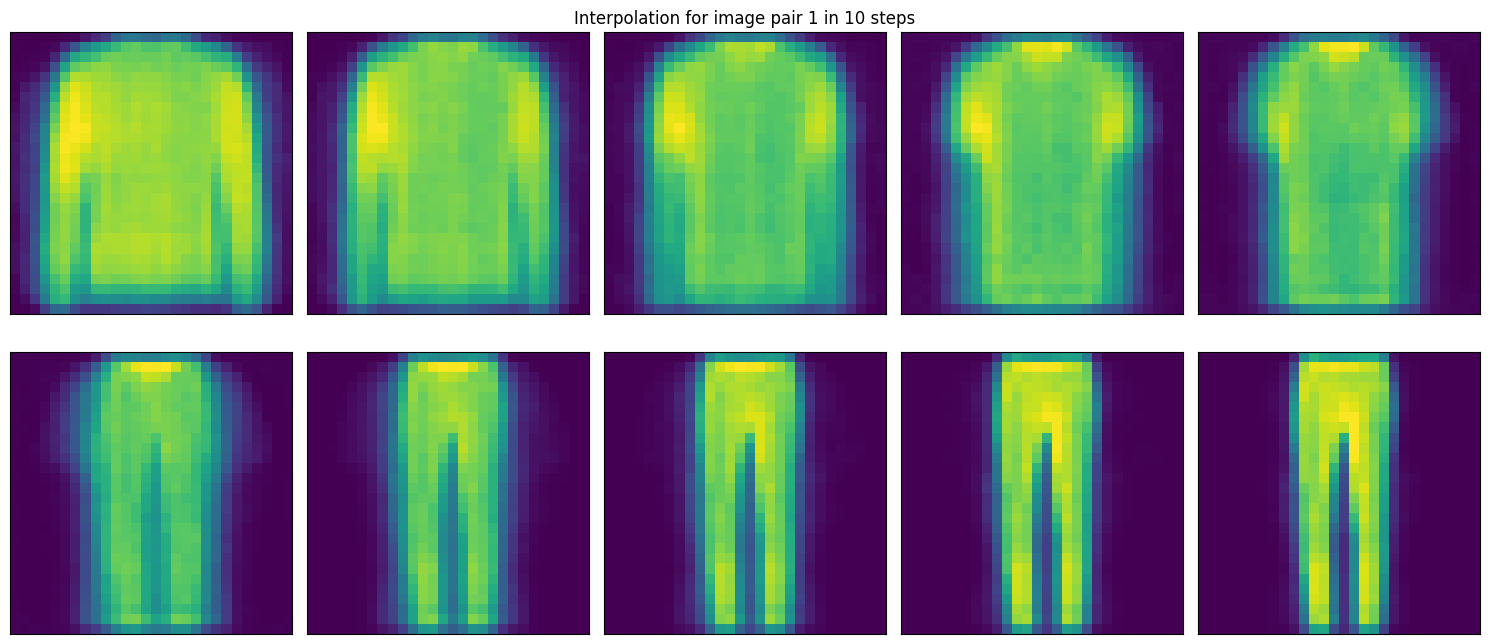

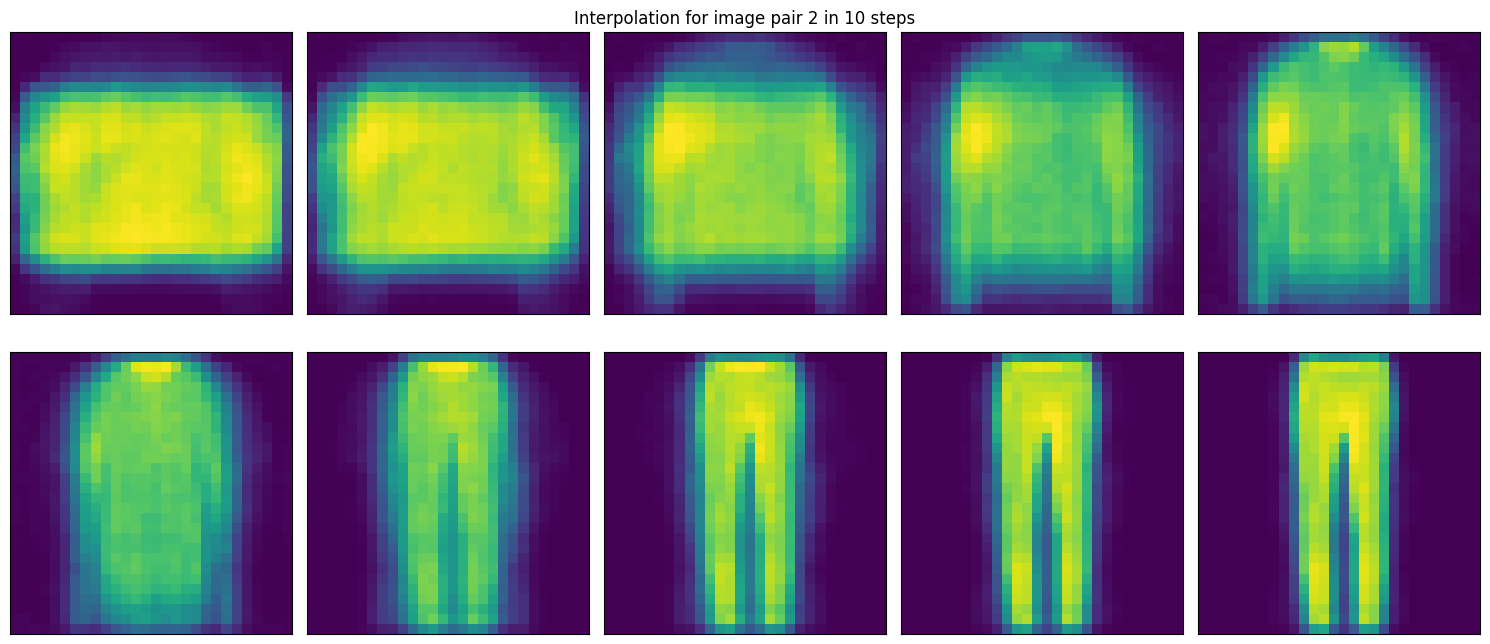

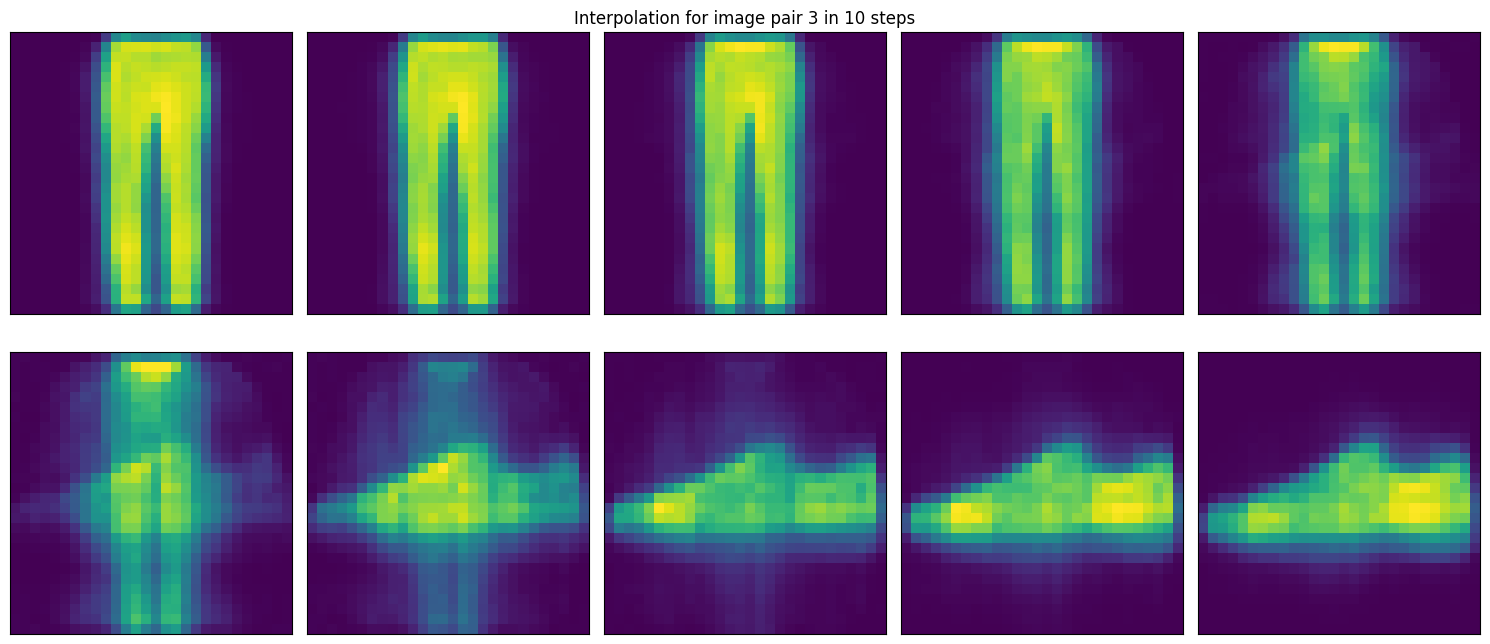

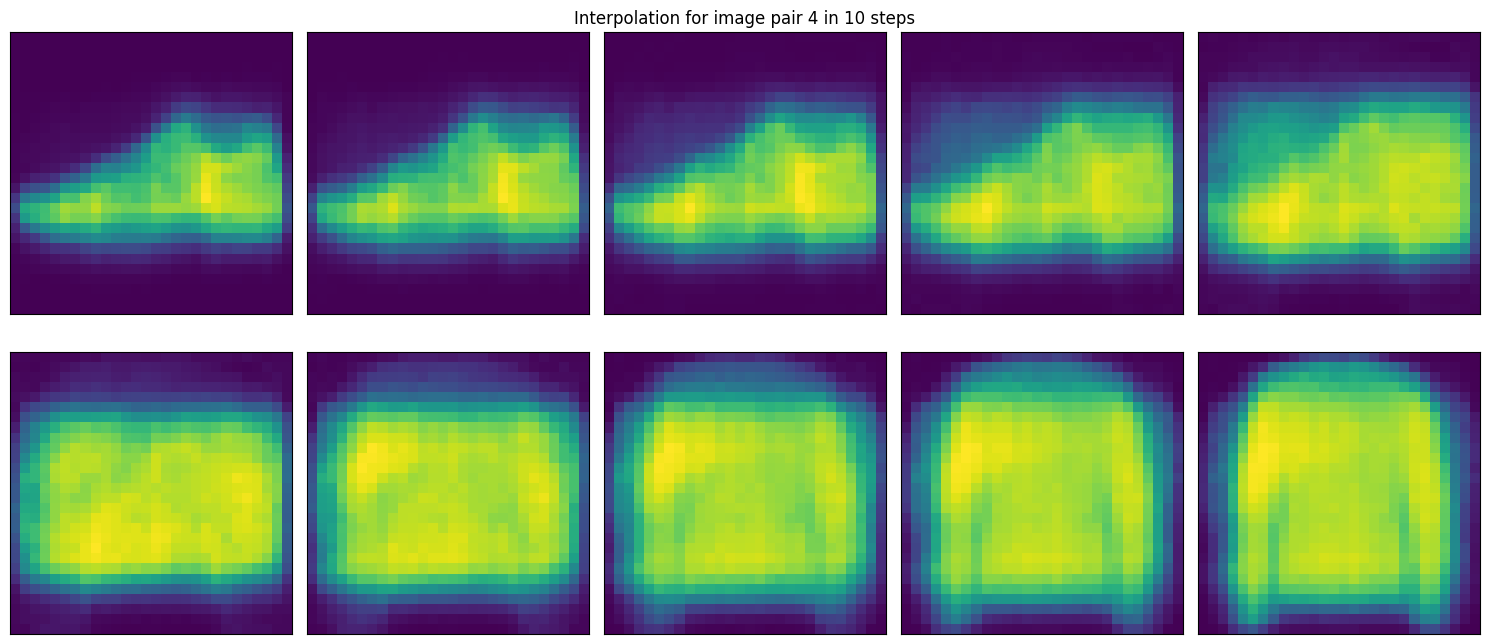

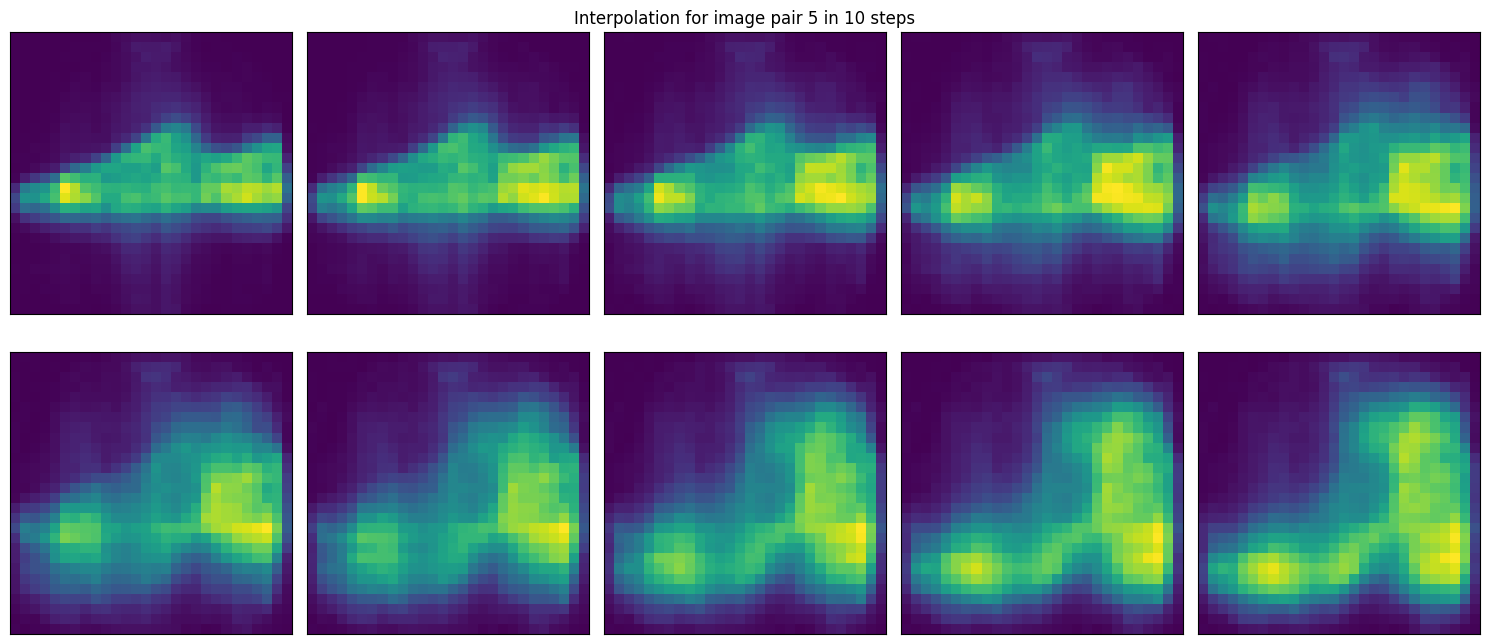

In [70]:
N = 10
for i, pair in enumerate(images_to_interpolate):
    image_A, image_B = img_batch[pair].view(-1, 28, 28).cpu()
    _, mean, _ = model(img_batch[pair])
    code = torch.Tensor(N, LATENT_DIM).to(DEVICE)
    for k in range(N):
        code[k] = (k / (N - 1)) * mean[1].data + (1 - (k / (N - 1))) * mean[0].data
    img_set = model.decoder(code)
    fig, axs = plt.subplots(2, 5, figsize=(15, 7))
    axs[0][2].set_title(f"Interpolation for image pair {i+1} in 10 steps")
    for j, ax in enumerate(axs):
        img_line = img_set[5 * j : 5 * (j + 1)]
        for k, a in enumerate(ax):
            a.imshow(img_line[k].view(28, 28).cpu().data)
            a.set_xticks([], [])
            a.set_yticks([], [])
    plt.tight_layout()
    plt.show()